# 1 Author

**Student Name**:  Zhong Zhenghan

**Student ID**:  210982480

**Github**:  https://github.com/buptxinghan/CBU5201_miniproject_Zhenghan

# 2 Problem formulation

- 使用 genki4k 数据集提出一个新的机器学习问题，例如性别分类或无监督聚类以发现模式。

# 3 Machine Learning pipeline

类似于基础部分，但根据新问题进行调整。

# 4 Transformation stage

可能包括与基础部分不同的转换步骤，这取决于问题的不同。

# 5 Modelling

选择适合新问题的模型。

# 6 Methodology

类似于基础部分，但可能包括额外或不同的评价指标。

# 7 Dataset

- 可能包括额外的注释或标签，如性别。
- 根据问题的不同，预处理可能有所不同。

# 8 Results

对新问题进行实验和分析。

# 9 Conclusions

讨论结果、潜在改进及未来工作，针对高级部分。

# 10 训练过程

In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


1. 定义自定义数据集类

In [2]:
class Genki4kDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'C:/Users/LENOVO/Desktop/MiniProject/MiniProject/genki4k/files' 
dataset = Genki4kDataset(data_dir, transform=data_transforms)


加载预训练模型并提取特征

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的 ResNet 模型
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for inputs in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
features = np.array(features)

2. 应用 K-means 聚类


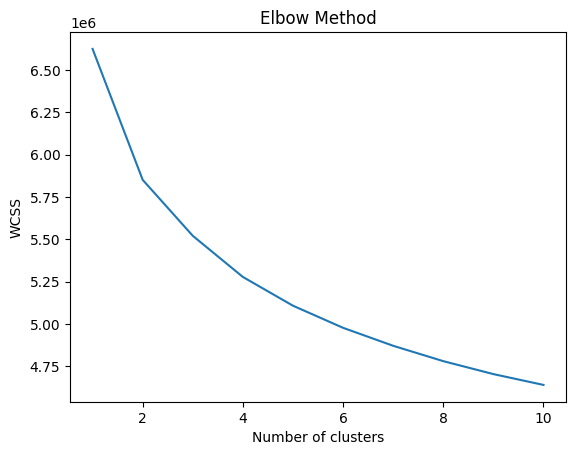

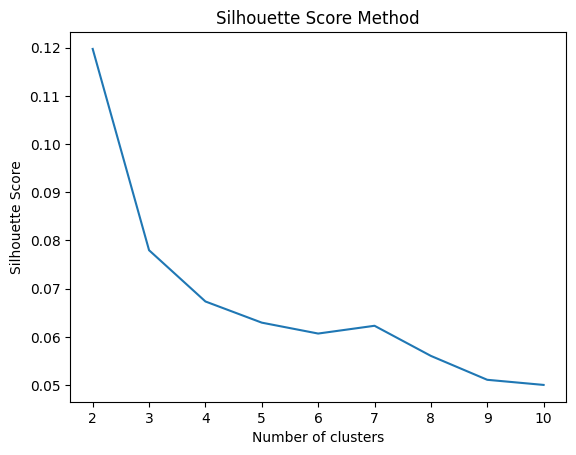

In [10]:
# 肘部法则
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

silhouette_scores = []
for i in range(2, 11):  # 轮廓系数至少需要2个聚类
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

- 肘部法则图：展示了聚类数量与聚类内误差平方和（WCSS）的关系。随着聚类数量的增加，WCSS 通常会减少，因为样本会更接近它们的中心点。肘部法则图通常呈现一个向下的弯曲，而“肘部”点是曲线开始平缓的地方，即增加更多聚类不会显著降低 WCSS 的点。从您的图中可以看出，当聚类数量从2增加到3时，WCSS的下降速度变缓，因此可能的最佳聚类数量为3。

- 轮廓系数图：表示不同聚类数量下的轮廓系数值。轮廓系数衡量了样本与同一聚类中其他样本的相似程度以及与最近的其他聚类样本的不同程度。轮廓系数的范围是 -1 到 1，值越高表示聚类效果越好。在您的图中，轮廓系数在聚类数量为2时最高，这表明在当前数据集上，两个聚类提供了最佳的分隔效果。

In [13]:
# 选择聚类的数量
n_clusters = 2 # 您可以根据需要调整聚类的数量

# 使用显式的 n_init 参数值, 执行K-means聚类
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(features)

KMeans(n_clusters=2, n_init=10, random_state=42)

3. 分析聚类结果

Silhouette Score: 0.11969465762376785


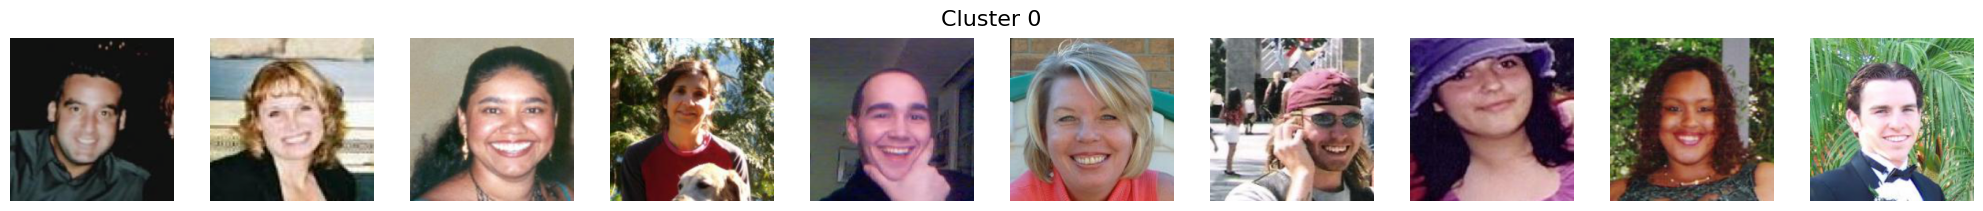

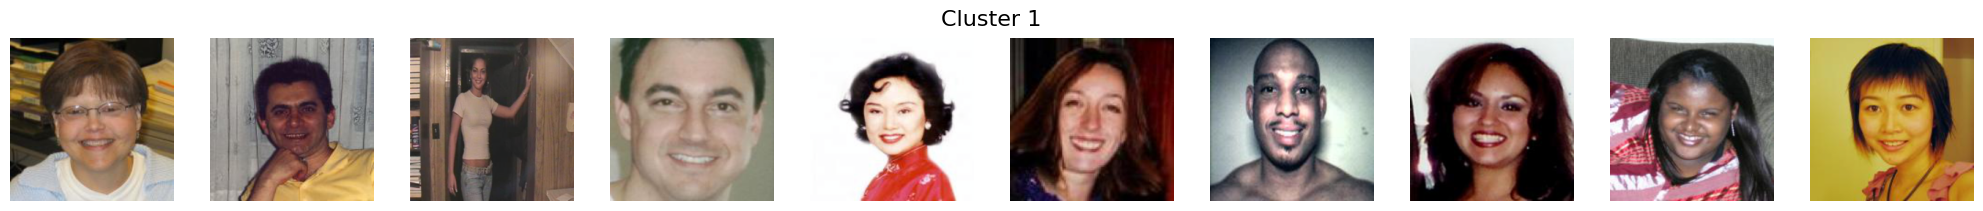

In [14]:

# 计算轮廓系数
silhouette_avg = silhouette_score(features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

labels = kmeans.labels_

for cluster in range(n_clusters):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2), constrained_layout=True)
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    cluster_indices = np.where(labels == cluster)[0]
    for ax, idx in zip(axes, cluster_indices[:10]):
        img = dataset[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


当轮廓系数相对较低时，这可能表明数据集的结构不适合通过 K-means 这种基于距离的聚类方法进行分割，或者数据集中的聚类可能是非球形的、大小不一的，或者聚类之间有重叠。因此我采用其他方法进行训练